# ПЛАН РАБОТЫ:

1. исследовательский анализ данных
2. обучение модели
3. анализ обученной модели

In [1]:
# импорт библиотек

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
print(f"Количество дубликатов: {labels.duplicated().sum()} \n")

Количество дубликатов: 0 



In [6]:
def data_box_hist(x):
    f, (ax_box, ax_hist) = plt.subplots(
                                2, 
                                sharex=True,
                                #figsize=(10, 6),
                                gridspec_kw={"height_ratios": (.15, .85)}
                                )

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, kde=True, ax=ax_hist)

    ax_box.set(yticks=[])
    ax_hist.set_ylabel('Количество')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xticks(rotation=45)
    return plt.show()

                    Распределение возраста в размеченных данных


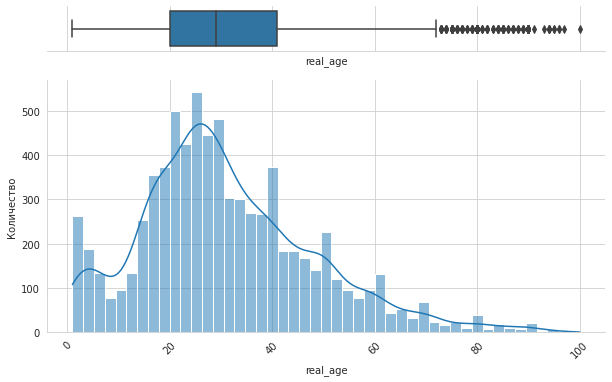

In [7]:
print(" " * 20 + "Распределение возраста в размеченных данных")
data_box_hist(labels['real_age'])

что можно сказать о возрастном распределении аудитории в размеченных данных: <br>
* средний возраст около 31 года.
* большинство &mdash; люди в возрасте от 20 до 41 лет, что указывает на преобладание молодой и средней возрастной группы.
* распределение, смещено вправо из-за наличия небольшого числа пожилых участников
* аномальные значения отсутствуют

теперь посмотрим на фотографии.

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


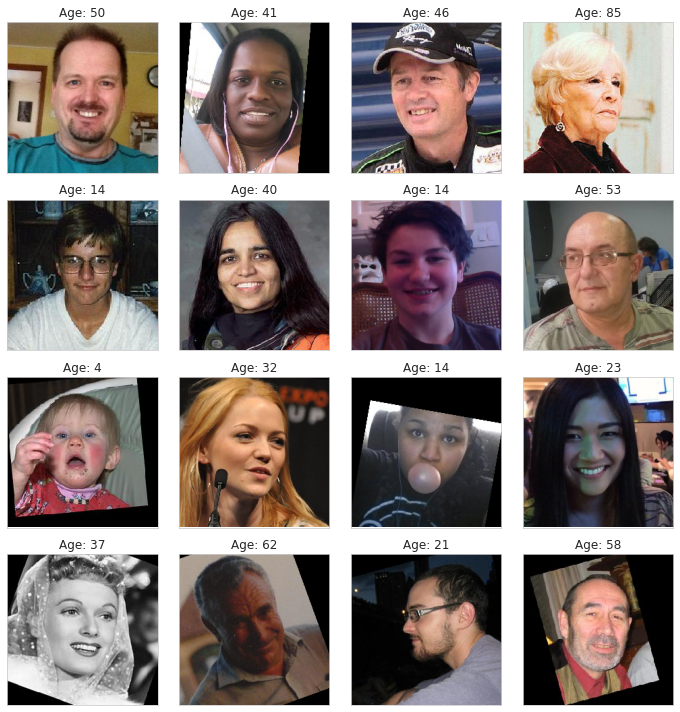

In [9]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**промежуточный вывод** <br>

<u>данные о возрасте:</u><br>
* в датасете 7591 фотография (сравнительно небольшая выборка для оценки возраста)
* преобладают фото людей от 20 лет до 41 года
* есть фото младенцев и людей старшего возраста:
    * для людей 60 лет и старше довольно мало примеров. можно предположить, что в этом возрастном диапазоне модель плохо обучится и будет длопускать ошибки в предсказании пожилых людей. 
    * довольно много фото детей младше 7. в целом неплохо, но для задачи заказчика ценности не представляет: дети дошкольного возраста не являются самостоятельной покупательской аудиторией и присутствуют в магазине в сопровождении родителей. при необходимости, для ускорения процесса обучения, эту возрастную категорию можно исключить без негативных последствий.
* распределение по возрастам выглядит нормальным, аномалий нет. 

<u>качество фото:</u><br>
* фотографии приемлемого качества, лица в фокусе, заметных искажений нет. для улучшения обучения будет полезно применить горизонтальный разворот изображений в обучающей выборке.
* на некоторых фотографиях присутствуют объекты, частично скрывающие лицо: головной убор, ладонь, пузырь жвачки и т.п.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow


def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
# < скопируйте результат вывода на экран сюда >
Train for 178 steps, validate for 60 steps

Epoch 1/10
2025-10-29 13:02:43.869991: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-10-29 13:02:45.154883: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 79s - loss: 196.2050 - mae: 10.2540 - val_loss: 405.6138 - val_mae: 15.1306

Epoch 2/10
178/178 - 47s - loss: 99.3395 - mae: 7.5347 - val_loss: 501.0898 - val_mae: 17.3053

Epoch 3/10
178/178 - 47s - loss: 70.1055 - mae: 6.3508 - val_loss: 322.5106 - val_mae: 13.4200

Epoch 4/10
178/178 - 47s - loss: 52.0635 - mae: 5.5293 - val_loss: 150.8646 - val_mae: 9.4611

Epoch 5/10
178/178 - 47s - loss: 43.7381 - mae: 5.0068 - val_loss: 95.8500 - val_mae: 7.2624

Epoch 6/10
178/178 - 47s - loss: 34.2157 - mae: 4.5016 - val_loss: 81.1311 - val_mae: 6.9930

Epoch 7/10
178/178 - 47s - loss: 27.0181 - mae: 3.9568 - val_loss: 93.8382 - val_mae: 7.6236

Epoch 8/10
178/178 - 47s - loss: 21.6521 - mae: 3.5594 - val_loss: 80.3801 - val_mae: 6.6745

Epoch 9/10
178/178 - 47s - loss: 18.1174 - mae: 3.2665 - val_loss: 84.2371 - val_mae: 7.1666

Epoch 10/10
178/178 - 47s - loss: 15.1430 - mae: 3.0016 - val_loss: 73.3396 - val_mae: 6.4311

60/60 - 10s - loss: 73.3396 - mae: 6.4311
```

## Анализ обученной модели

по условию задачи было необходимо обучить модель, способную определять возраст покупателя по изображению с камеры. 
критерием качества являлось среднее абсолютное отклонение (**MAE**) не выше **`8`**.
<br>
для решения задачи использовался размеченный набор данных из **`7591`** фотографии людей разных возрастных групп.  
анализ датасета показал:
- большинство изображений относятся к людям **`от 20 до 40 лет`**;  
- датасет содержит недостаточное количество снимков пожилых людей;  
- фотографии сделаны в разных условиях освещения, на некоторых снимках лица частично скрыты, что повышает сложность задачи.

для повышения обобщающей способности модели использовались **аугментации изображений** (повороты, сдвиги, отражения), что позволило увеличить разнообразие тренировочной выборки.


в качестве архитектуры модели выбрана **`ResNet50`**, предобученная на ImageNet.  
поверх свёрточной части была добавлена операция **`GlobalAveragePooling2D`** и один полносвязный слой для предсказания возраста.  
модель обучалась с оптимизатором **Adam (`learning_rate = 0.003`)** и функцией потерь **Mean Squared Error (`MSE`)**.


После обучения модель показала метрику **`MAE=6.43`**, что меньше требуемого порога (8). таким образом, модель успешно справилась с поставленной задачей и может использоваться для прогнозирования возраста покупателей по фотографиям.

---

<u>интерпретация результата для бизнеса</u>

средняя ошибка в 6 лет говорит о том, что модель в среднем ошибается в определении возраста не более чем на ±6 лет,  
что является приемлемым уровнем точности для анализа покупательской активности и контроля возрастных ограничений при продаже алкоголя.

при этом:
- возможны ошибки при оценке возраста в случае нестандартных ракурсов, тяжёлого макияжа или сильных теней.  
- недостаточное представление некоторых возрастных категорий в обучающем наборе может снижать точность на этих группах.

---

<u>что можно улучшить в дальнейшем</u>

- **Балансировка выборки** &mdash; добавить больше изображений людей старших возрастных групп.  
- **Увеличение разрешения изображений** (например, 224×224 вместо 150×150) для повышения детализации.  
- **Тонкая настройка гиперпараметров** (learning rate, количество эпох, размер батча) может дополнительно снизить MAE.
- **Дополнительные фото с разметкой** &mdash; больше фотографий для возрастной категории 15-20 лет поможет модели точнее определять возраст подростков.